In [1]:
import re
import string

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from collections import Counter

import spacy
from spacy.lang.en.stop_words import STOP_WORDS

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

from sklearn.metrics import confusion_matrix, classification_report, RocCurveDisplay

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, Normalizer

import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional

from sentence_transformers import SentenceTransformer

/Users/doski/miniconda3/envs/getinno-env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_json('../Datasets/sarcasm_data.json')

In [3]:
data.head()

,160,170,180,190,1105,1162,1175,1182,1213,1276,...,2623,2131,2236,2546,2242,2169,2235,234,2608,2524
utterance,It's just a privilege to watch your mind at work.,I don't think I'll be able to stop thinking ab...,"Since it's not bee season, you can have my epi...","Lois Lane is falling, accelerating at an initi...",I'm just inferring this is a couch because the...,"Sheldon, if you were a robot, and I knew and y...",If you're compiling a mix CD for a double suic...,No. The dark crescent-shaped patterns under yo...,"How's this? ""Pleased to meet you, Dr. Gablehau...","Yeah, my parents felt that naming me Leonard a...",...,What do you know? Its a treat for the eyes and...,I really don't wanna sit with Allen Iverson ov...,"Gee, if only she were one and had no idea what...","Oh sure, she was probably up all night excited...",Are you still enjoying your nap?,"Hes not right for the part, and if I suggest h...","Oh yeah he has a caretaker his older brother, ...",Is it me or the greetings gone downhill around...,"You are right, by saying nice, I am virtually ...","Yes and we are ""very"" excited about it."
speaker,SHELDON,PENNY,SHELDON,SHELDON,SHELDON,HOWARD,SHELDON,SHELDON,SHELDON,LEONARD,...,CHANDLER,CHANDLER,CHANDLER,CHANDLER,CHANDLER,CHANDLER,CHANDLER,CHANDLER,CHANDLER,CHANDLER
context,[I never would have identified the fingerprint...,[This is one of my favorite places to kick bac...,"[Here we go. Pad thai, no peanuts., But does i...",[A marathon? How many Superman movies are ther...,"[Great Caesar's ghost, look at this place., So...","[On the other hand, no arousal., None?, None.,...","[Oh, good Lord., God, that's a good song.]","[How do I look?, Could you be more specific?, ...","[You know, I am not going to enjoy this party....",[He switched over to high-energy radiation res...,...,"[Chandler?, Hey! Ah!, What do you think?, I th...",[Wish I could switch with someone.],"[You can't go away this weekend, its Emma's bi...","[Hey, Hey, where's the birthday girl?, Oh she ...","[Okay?, Hi Emma, it's the year 2020.]","[What am I gonna do now?, Just pass the tape a...","[Helo! Anybody in there order a celebrity?, Wh...","[Hey, You son of a bitch!]","[Did I go to this school?, Hey, there's Missy ...","[Anyway, if you don't feel like being alone to..."
context_speakers,"[LEONARD, SHELDON]","[HOWARD, PENNY, HOWARD, HOWARD, HOWARD, PENNY,...","[LEONARD, HOWARD, LEONARD]","[PENNY, SHELDON, PENNY, SHELDON, SHELDON, PENN...","[SHELDON, LEONARD, SHELDON, SHELDON, SHELDON, ...","[PERSON, LEONARD, PERSON, LEONARD, PERSON, LEO...","[SHELDON, LEONARD]","[LEONARD, SHELDON, LEONARD]","[SHELDON, LEONARD, SHELDON, LEONARD, SHELDON, ...","[PERSON, PERSON, LEONARD, PERSON, LEONARD, PER...",...,"[PHOEBE, CHANDLER, MONICA, CHANDLER]",[CHANDLER],"[RACHEL, MONICA, RACHEL]","[MONICA, CHANDLER, RACHEL]","[ROSS, CHANDLER]","[CHANDLER, RACHEL]","[JOEY, PERSON, CHANDLER, PERSON]","[CHANDLER, JOEY]","[CHANDLER, ROSS, CHANDLER, ROSS]",[ROSS]
show,BBT,BBT,BBT,BBT,BBT,BBT,BBT,BBT,BBT,BBT,...,FRIENDS,FRIENDS,FRIENDS,FRIENDS,FRIENDS,FRIENDS,FRIENDS,FRIENDS,FRIENDS,FRIENDS


In [4]:
data = data.T

In [5]:
data.head()

,utterance,speaker,context,context_speakers,show,sarcasm
160,It's just a privilege to watch your mind at work.,SHELDON,[I never would have identified the fingerprint...,"[LEONARD, SHELDON]",BBT,True
170,I don't think I'll be able to stop thinking ab...,PENNY,[This is one of my favorite places to kick bac...,"[HOWARD, PENNY, HOWARD, HOWARD, HOWARD, PENNY,...",BBT,True
180,"Since it's not bee season, you can have my epi...",SHELDON,"[Here we go. Pad thai, no peanuts., But does i...","[LEONARD, HOWARD, LEONARD]",BBT,False
190,"Lois Lane is falling, accelerating at an initi...",SHELDON,[A marathon? How many Superman movies are ther...,"[PENNY, SHELDON, PENNY, SHELDON, SHELDON, PENN...",BBT,False
1105,I'm just inferring this is a couch because the...,SHELDON,"[Great Caesar's ghost, look at this place., So...","[SHELDON, LEONARD, SHELDON, SHELDON, SHELDON, ...",BBT,True


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 690 entries, 160 to 2524
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   utterance         690 non-null    object
 1   speaker           690 non-null    object
 2   context           690 non-null    object
 3   context_speakers  690 non-null    object
 4   show              690 non-null    object
 5   sarcasm           690 non-null    object
dtypes: object(6)
memory usage: 53.9+ KB


In [7]:
data.show.value_counts(dropna=False)

FRIENDS           356
BBT               280
GOLDENGIRLS        40
SARCASMOHOLICS     14
Name: show, dtype: int64

In [8]:
data.sarcasm.value_counts(dropna=False)

True     345
False    345
Name: sarcasm, dtype: int64

In [9]:
data.rename(columns={'utterance': 'comment', 'sarcasm': 'label'}, inplace=True)

In [10]:
df = data[['comment', 'label']].reset_index()

In [11]:
df['comment'] = df['comment'].str.lower()

In [12]:
df.head()

,index,comment,label
0,160,it's just a privilege to watch your mind at work.,True
1,170,i don't think i'll be able to stop thinking ab...,True
2,180,"since it's not bee season, you can have my epi...",False
3,190,"lois lane is falling, accelerating at an initi...",False
4,1105,i'm just inferring this is a couch because the...,True


In [13]:
df.replace({'label': {True: 1, False: 0}}, inplace=True)

In [14]:
df.head()

,index,comment,label
0,160,it's just a privilege to watch your mind at work.,1
1,170,i don't think i'll be able to stop thinking ab...,1
2,180,"since it's not bee season, you can have my epi...",0
3,190,"lois lane is falling, accelerating at an initi...",0
4,1105,i'm just inferring this is a couch because the...,1


In [15]:
df['comment_words'] = df['comment'].apply(lambda x: x.split(' '))

In [16]:
df['message_len'] = df['comment_words'].apply(len)

In [17]:
df.head()

,index,comment,label,comment_words,message_len
0,160,it's just a privilege to watch your mind at work.,1,"[it's, just, a, privilege, to, watch, your, mi...",10
1,170,i don't think i'll be able to stop thinking ab...,1,"[i, don't, think, i'll, be, able, to, stop, th...",11
2,180,"since it's not bee season, you can have my epi...",0,"[since, it's, not, bee, season,, you, can, hav...",10
3,190,"lois lane is falling, accelerating at an initi...",0,"[lois, lane, is, falling,, accelerating, at, a...",51
4,1105,i'm just inferring this is a couch because the...,1,"[i'm, just, inferring, this, is, a, couch, bec...",20


In [18]:
Counter(df.comment_words.sum()).most_common(100)

[('i', 267),
 ('a', 257),
 ('the', 244),
 ('you', 228),
 ('to', 212),
 ('and', 146),
 ('of', 123),
 ('in', 99),
 ('that', 90),
 ('it', 77),
 ('my', 75),
 ('is', 75),
 ('just', 71),
 ("i'm", 65),
 ('was', 63),
 ('have', 60),
 ("don't", 55),
 ('for', 55),
 ('with', 55),
 ('on', 54),
 ('all', 51),
 ('your', 50),
 ('not', 49),
 ('if', 49),
 ('we', 49),
 ('what', 48),
 ("it's", 46),
 ('me', 45),
 ('but', 44),
 ('like', 43),
 ('no,', 42),
 ('no', 41),
 ('so', 41),
 ('do', 41),
 ('this', 40),
 ('about', 39),
 ('oh,', 37),
 ('are', 37),
 ('he', 35),
 ('be', 34),
 ('am', 33),
 ('an', 32),
 ('out', 32),
 ("you're", 32),
 ('oh', 32),
 ('can', 31),
 ('she', 31),
 ('at', 29),
 ('think', 28),
 ('go', 27),
 ('yeah,', 26),
 ('well,', 26),
 ('when', 26),
 ('her', 25),
 ('because', 25),
 ('up', 24),
 ('how', 24),
 ('see', 24),
 ('it.', 23),
 ('got', 23),
 ('know', 23),
 ("that's", 23),
 ('would', 22),
 ('going', 22),
 ('really', 22),
 ('you.', 21),
 ('good', 21),
 ('get', 21),
 ('gonna', 21),
 ('as', 20

In [19]:
df['comment_words'] = df['comment_words'].apply(
    lambda x: [''.join(re.findall('[\s\w\d]', word)) for word in x if (
        (word not in string.punctuation) and (word not in STOP_WORDS)
    )]
)

In [20]:
df.head()

,index,comment,label,comment_words,message_len
0,160,it's just a privilege to watch your mind at work.,1,"[its, privilege, watch, mind, work]",10
1,170,i don't think i'll be able to stop thinking ab...,1,"[dont, think, ill, able, stop, thinking, it]",11
2,180,"since it's not bee season, you can have my epi...",0,"[its, bee, season, epinephrine]",10
3,190,"lois lane is falling, accelerating at an initi...",0,"[lois, lane, falling, accelerating, initial, r...",51
4,1105,i'm just inferring this is a couch because the...,1,"[im, inferring, couch, evidence, suggests, cof...",20


In [21]:
en_model = spacy.load('en_core_web_sm')

In [22]:
df['lemma'] = df['comment_words'].apply(lambda x: ' '.join([token.lemma_ for token in en_model(' '.join(x))]))

In [23]:
df['embeddings'] = df['comment'].apply(lambda x: [np.mean(token.vector) for token in en_model(x)])

In [24]:
df.head()

,index,comment,label,comment_words,message_len,lemma,embeddings
0,160,it's just a privilege to watch your mind at work.,1,"[its, privilege, watch, mind, work]",10,its privilege watch mind work,"[-0.03240213, -0.02640604, 0.0010467073, -0.02..."
1,170,i don't think i'll be able to stop thinking ab...,1,"[dont, think, ill, able, stop, thinking, it]",11,do not think ill able stop think it,"[-0.009132788, 0.0069183805, 0.04031159, -0.03..."
2,180,"since it's not bee season, you can have my epi...",0,"[its, bee, season, epinephrine]",10,its bee season epinephrine,"[0.014771591, -0.016912768, -0.01538005, 0.013..."
3,190,"lois lane is falling, accelerating at an initi...",0,"[lois, lane, falling, accelerating, initial, r...",51,lois lane fall accelerate initial rate 32 foot...,"[-0.013496977, -0.015611366, 0.010337063, 0.00..."
4,1105,i'm just inferring this is a couch because the...,1,"[im, inferring, couch, evidence, suggests, cof...",20,I m infer couch evidence suggest coffee table ...,"[-0.0077959597, -0.028534317, 0.019402007, -0...."


In [25]:
reddit_data = pd.read_csv('../Datasets/clean_reddit_data.csv')

In [26]:
reddit_data.label.value_counts(dropna=False)

0    505413
1    505413
Name: label, dtype: int64

In [27]:
reddit_data['source'] = 'reddit'
df['source'] = 'movies'

In [28]:
combined_df = pd.concat([df, reddit_data], ignore_index=True)

In [29]:
combined_df.label.value_counts(dropna=False)

1    505758
0    505758
Name: label, dtype: int64

In [30]:
combined_df.fillna(' ', inplace=True)

In [31]:
combined_df.head()

,index,comment,label,comment_words,message_len,lemma,embeddings,source
0,160.0,it's just a privilege to watch your mind at work.,1,"[its, privilege, watch, mind, work]",10.0,its privilege watch mind work,"[-0.03240213, -0.02640604, 0.0010467073, -0.02...",movies
1,170.0,i don't think i'll be able to stop thinking ab...,1,"[dont, think, ill, able, stop, thinking, it]",11.0,do not think ill able stop think it,"[-0.009132788, 0.0069183805, 0.04031159, -0.03...",movies
2,180.0,"since it's not bee season, you can have my epi...",0,"[its, bee, season, epinephrine]",10.0,its bee season epinephrine,"[0.014771591, -0.016912768, -0.01538005, 0.013...",movies
3,190.0,"lois lane is falling, accelerating at an initi...",0,"[lois, lane, falling, accelerating, initial, r...",51.0,lois lane fall accelerate initial rate 32 foot...,"[-0.013496977, -0.015611366, 0.010337063, 0.00...",movies
4,1105.0,i'm just inferring this is a couch because the...,1,"[im, inferring, couch, evidence, suggests, cof...",20.0,I m infer couch evidence suggest coffee table ...,"[-0.0077959597, -0.028534317, 0.019402007, -0....",movies


In [32]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1011516 entries, 0 to 1011515
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   index          1011516 non-null  object
 1   comment        1011516 non-null  object
 2   label          1011516 non-null  int64 
 3   comment_words  1011516 non-null  object
 4   message_len    1011516 non-null  object
 5   lemma          1011516 non-null  object
 6   embeddings     1011516 non-null  object
 7   source         1011516 non-null  object
dtypes: int64(1), object(7)
memory usage: 61.7+ MB


In [33]:
reddit_data.fillna(' ', inplace=True)
df.fillna(' ', inplace=True)

In [34]:
reddit_data['embeddings_'] = reddit_data['embeddings'].apply(
    lambda x: list(map(lambda y: float(y.strip()), x.strip('[]').split(','))) if type(x) == str else x
)

In [35]:
reddit_data['embeddings_mean'] = reddit_data['embeddings_'].apply(np.mean)
reddit_data['embeddings_mid'] = reddit_data['embeddings_'].apply(np.median)
reddit_data['embeddings_std'] = reddit_data['embeddings_'].apply(np.std)

In [36]:
df['embeddings_'] = df['embeddings'].apply(
    lambda x: list(map(lambda y: float(y.strip()), x.strip('[]').split(','))) if type(x) == str else x
)

In [37]:
df['embeddings_mean'] = df['embeddings_'].apply(np.mean)
df['embeddings_mid'] = df['embeddings_'].apply(np.median)
df['embeddings_std'] = df['embeddings_'].apply(np.std)

In [38]:
train_reddit, test_reddit = train_test_split(
    reddit_data, 
    train_size=10000-int(345*0.6),
    random_state=9
)

In [39]:
train_movies, test_movies = train_test_split(
    df,
    train_size=0.6,
    random_state=9
)

In [40]:
train = pd.concat([train_reddit, train_movies], ignore_index=True)
test = pd.concat([test_reddit, test_movies], ignore_index=True)

In [41]:
train.groupby(['source', 'label']).count()

lemma  comment  comment_words  embeddings  embeddings_  \
source label                                                           
movies 0        199      199            199         199          199   
       1        215      215            215         215          215   
reddit 0       4930     4930           4930        4930         4930   
       1       4863     4863           4863        4863         4863   

              embeddings_mean  embeddings_mid  embeddings_std  index  \
source label                                                           
movies 0                  199             199             199    199   
       1                  215             215             215    215   
reddit 0                 4930            4930            4930      0   
       1                 4863            4863            4863      0   

              message_len  
source label               
movies 0              199  
       1              215  
reddit 0                0  
       1                0

In [42]:
test.groupby(['source', 'label']).count()

lemma  comment  comment_words  embeddings  embeddings_  \
source label                                                            
movies 0         146      146            146         146          146   
       1         130      130            130         130          130   
reddit 0      500483   500483         500483      500483       500483   
       1      500550   500550         500550      500550       500550   

              embeddings_mean  embeddings_mid  embeddings_std  index  \
source label                                                           
movies 0                  146             146             146    146   
       1                  130             130             130    130   
reddit 0               500483          500483          500483      0   
       1               500550          500550          500550      0   

              message_len  
source label               
movies 0              146  
       1              130  
reddit 0                0  
       1                0

**Sarcasm Prediction using Lemmatized text after removing stopwords**

In [43]:
# Split data into train-test chunks
Xtrain = train[['lemma']]
Xtest = test[['lemma']]
ytrain = train[['label']]
ytest = test[['label']]

In [44]:
# Column transformer to create unigram bag of words in pipeline
transformer_bagging = ColumnTransformer(
    [('transformer_bagging', CountVectorizer(ngram_range=(1, 2)), 'lemma')], 
    remainder='passthrough'
)

In [45]:
# Pipeline to create bag of words, test scalling the data, then test various models
pipe = Pipeline([
    ('transform', transformer_bagging),
    ('preprocess', None),
    ('model', LogisticRegression())
])

In [46]:
# Set grid search parameters
hyperparams = {
    #'preprocess': [StandardScaler(with_mean=False), MaxAbsScaler(), Normalizer(copy=False), None],
    'model': [LogisticRegression(), MLPClassifier(max_iter=1000)]
    # [LinearSVC(), LogisticRegression(), DecisionTreeClassifier(), RandomForestClassifier(), 
    #          GradientBoostingClassifier(), GaussianNB(), MLPClassifier()],
    #'transform__transformer_bagging__ngram_range': [(1, 1), (1, 2), (1, 3)]
}

In [47]:
# Configure pipeline for grid search
grid = GridSearchCV(
    estimator=pipe,
    param_grid=hyperparams,
    scoring='roc_auc',
    n_jobs=-1,
    cv=2
)

In [48]:
# Train a pipeline using the grid search settings to predict sarcasm
cv = grid.fit(Xtrain, ytrain)

/Users/doski/miniconda3/envs/getinno-env/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [49]:
cv.best_estimator_

Pipeline(steps=[('transform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('transformer_bagging',
                                                  CountVectorizer(ngram_range=(1,
                                                                               2)),
                                                  'lemma')])),
                ('preprocess', None), ('model', LogisticRegression())])

In [50]:
cv.best_score_

0.6467657884446474

In [51]:
# Evaluate best model on test data
pred = cv.best_estimator_.predict(Xtest)

In [52]:
# View the classification report
print(classification_report(ytest, pred))

              precision    recall  f1-score   support

           0       0.61      0.69      0.65    500629
           1       0.64      0.55      0.59    500680

    accuracy                           0.62   1001309
   macro avg       0.62      0.62      0.62   1001309
weighted avg       0.62      0.62      0.62   1001309



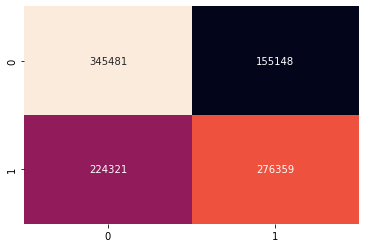

In [53]:
# Plot the confusion matrix
ax = sns.heatmap(
    confusion_matrix(ytest, pred), 
    annot=True, 
    cbar=False, 
    fmt='d'
)

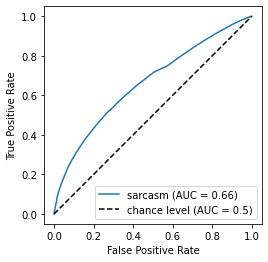

In [54]:
# Plot ROC and get the AUC value
ax = RocCurveDisplay.from_estimator(
    cv.best_estimator_,
    Xtest,
    ytest,
    name='sarcasm'
)
plt.plot([0, 1], [0, 1], 'k--', label='chance level (AUC = 0.5)')
plt.axis('square')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

**Sarcasm Prediction using raw text**

In [55]:
# Split data into train-test chunks
Xtrain = train[['comment']]
Xtest = test[['comment']]
ytrain = train[['label']]
ytest = test[['label']]

In [56]:
# Column transformer to create unigram bag of words in pipeline
transformer_bagging = ColumnTransformer(
    [('transformer_bagging', CountVectorizer(ngram_range=(1, 1)), 'comment')], 
    remainder='passthrough'
)

In [57]:
# Pipeline to create bag of words, test scalling the data, then test various models
pipe = Pipeline([
    ('transform', transformer_bagging),
    ('preprocess', None),
    ('model', LogisticRegression())
])

In [58]:
# Set grid search parameters
hyperparams = {
    #'preprocess': [StandardScaler(with_mean=False), MaxAbsScaler(), Normalizer(copy=False), None],
    'model': [LogisticRegression(), MLPClassifier(max_iter=1000)]
    # [LinearSVC(), LogisticRegression(), DecisionTreeClassifier(), RandomForestClassifier(), 
    #          GradientBoostingClassifier(), GaussianNB(), MLPClassifier()],
    #'transform__transformer_bagging__ngram_range': [(1, 1), (1, 2), (1, 3)]
}

In [59]:
# Configure pipeline for grid search
grid = GridSearchCV(
    estimator=pipe,
    param_grid=hyperparams,
    scoring='roc_auc',
    n_jobs=-1,
    cv=2
)

In [60]:
# Train a pipeline using the grid search settings to predict sarcasm
cv = grid.fit(Xtrain, ytrain)

/Users/doski/miniconda3/envs/getinno-env/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/doski/miniconda3/envs/getinno-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [61]:
cv.best_estimator_

Pipeline(steps=[('transform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('transformer_bagging',
                                                  CountVectorizer(),
                                                  'comment')])),
                ('preprocess', None), ('model', LogisticRegression())])

In [62]:
cv.best_score_

0.6674022917387563

In [63]:
# Evaluate best model on test data
pred = cv.best_estimator_.predict(Xtest)

In [64]:
# View the classification report
print(classification_report(ytest, pred))

              precision    recall  f1-score   support

           0       0.63      0.68      0.65    500629
           1       0.65      0.60      0.62    500680

    accuracy                           0.64   1001309
   macro avg       0.64      0.64      0.64   1001309
weighted avg       0.64      0.64      0.64   1001309



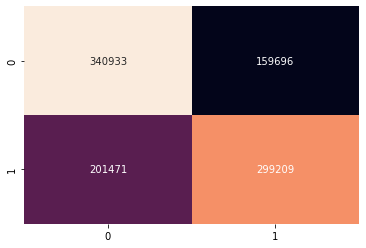

In [65]:
# Plot the confusion matrix
ax = sns.heatmap(
    confusion_matrix(ytest, pred), 
    annot=True, 
    cbar=False, 
    fmt='d'
)

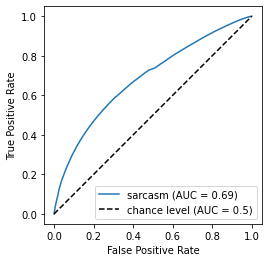

In [66]:
# Plot ROC and get the AUC value
ax = RocCurveDisplay.from_estimator(
    cv.best_estimator_,
    Xtest,
    ytest,
    name='sarcasm'
)
plt.plot([0, 1], [0, 1], 'k--', label='chance level (AUC = 0.5)')
plt.axis('square')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

**Sarcasm Prediction using word embeddings on raw text**

In [67]:
# Split data into train-test chunks
Xtrain = train[['embeddings_mean', 'embeddings_mid', 'embeddings_std']]
Xtest = test[['embeddings_mean', 'embeddings_mid', 'embeddings_std']]
ytrain = train[['label']]
ytest = test[['label']]

In [68]:
# Pipeline to create bag of words, test scalling the data, then test various models
pipe = Pipeline([
    ('preprocess', None),
    ('model', LogisticRegression())
])

In [69]:
# Set grid search parameters
hyperparams = {
    'preprocess': [StandardScaler(with_mean=False), MaxAbsScaler(), Normalizer(copy=False), None],
    'model': [LinearSVC(), LogisticRegression(), DecisionTreeClassifier(), RandomForestClassifier(), 
             GradientBoostingClassifier(), GaussianNB(), MLPClassifier()]
}

In [70]:
# Configure pipeline for grid search
grid = GridSearchCV(
    estimator=pipe,
    param_grid=hyperparams,
    scoring='roc_auc',
    n_jobs=-1,
    cv=2
)

In [71]:
# Train a pipeline using the grid search settings to predict sarcasm
cv = grid.fit(Xtrain, ytrain)

/Users/doski/miniconda3/envs/getinno-env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [72]:
cv.best_estimator_

Pipeline(steps=[('preprocess', StandardScaler(with_mean=False)),
                ('model', MLPClassifier())])

In [73]:
cv.best_score_

0.5523101135875391

In [74]:
# Evaluate best model on test data
pred = cv.best_estimator_.predict(Xtest)

In [75]:
# View the classification report
print(classification_report(ytest, pred))

              precision    recall  f1-score   support

           0       0.56      0.30      0.39    500629
           1       0.52      0.76      0.62    500680

    accuracy                           0.53   1001309
   macro avg       0.54      0.53      0.51   1001309
weighted avg       0.54      0.53      0.51   1001309



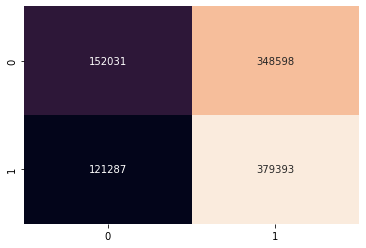

In [76]:
# Plot the confusion matrix
ax = sns.heatmap(
    confusion_matrix(ytest, pred), 
    annot=True, 
    cbar=False, 
    fmt='d'
)

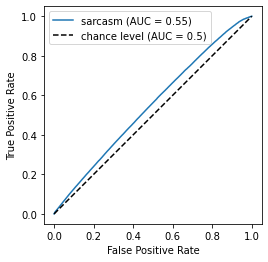

In [77]:
# Plot ROC and get the AUC value
ax = RocCurveDisplay.from_estimator(
    cv.best_estimator_,
    Xtest,
    ytest,
    name='sarcasm'
)
plt.plot([0, 1], [0, 1], 'k--', label='chance level (AUC = 0.5)')
plt.axis('square')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

**Sarcasm Prediction using Dense Neural Networks on bag of words**

In [78]:
# Split data into train-test chunks
_, __ = train_test_split(test, test_size=2000)
Xtrain = train[['lemma']]
Xtest = __[['lemma']]
ytrain = train[['label']]
ytest = __[['label']]

In [79]:
# Column transformer to create unigram bag of words in pipeline
transformer_bagging = ColumnTransformer(
    [('transformer_bagging', CountVectorizer(ngram_range=(1, 2)), 'lemma')], 
    remainder='passthrough',
    sparse_threshold=0
)

In [80]:
bagger = transformer_bagging.fit(Xtrain)

In [81]:
X_train = np.asarray(bagger.transform(Xtrain))
y_train = ytrain.values

In [82]:
X_test = np.asarray(bagger.transform(Xtest))
y_test = ytest.values

In [83]:
# Initializing the neural network
model = Sequential()

# hidden layer with 5 nodes using the relu activation function
model.add(Dense(units=5, kernel_initializer='uniform', activation='relu'))

# Output layer with 1 node using the sigmoid activation function
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compile the neural network
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = [tensorflow.keras.metrics.AUC(), 
                                                                           'accuracy'])

# Uncomment to train the model
model.fit(X_train, ytrain, batch_size=10, epochs=5)

Epoch 1/5
1021/1021 [==============================] - 8s 7ms/step - loss: 0.6846 - auc: 0.6018 - accuracy: 0.5729
Epoch 2/5
1021/1021 [==============================] - 6s 6ms/step - loss: 0.5176 - auc: 0.8702 - accuracy: 0.7965
Epoch 3/5
1021/1021 [==============================] - 5s 5ms/step - loss: 0.2823 - auc: 0.9740 - accuracy: 0.9092
Epoch 4/5
1021/1021 [==============================] - 6s 6ms/step - loss: 0.1621 - auc: 0.9927 - accuracy: 0.9546
Epoch 5/5
1021/1021 [==============================] - 5s 5ms/step - loss: 0.1049 - auc: 0.9971 - accuracy: 0.9714


In [84]:
# Use the model for predictions and convert probabilities above 0.5 to 1
y_pred = model.predict(X_test)
y_pred = y_pred > 0.5

63/63 [==============================] - 1s 10ms/step


In [85]:
# View the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.61      0.61      1006
           1       0.61      0.61      0.61       994

    accuracy                           0.61      2000
   macro avg       0.61      0.61      0.61      2000
weighted avg       0.61      0.61      0.61      2000



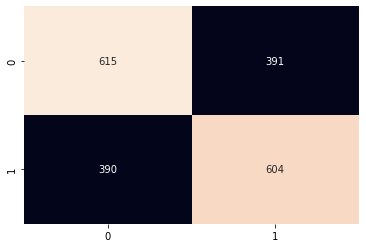

In [86]:
# Plot the confusion matrix
ax = sns.heatmap(
    confusion_matrix(y_test, y_pred), 
    annot=True, 
    cbar=False, 
    fmt='d'
)

**Sarcasm Prediction using Dense Neural Networks on Word Embeddings**

In [87]:
# Split data into train-test chunks
Xtrain = train[['embeddings_mean', 'embeddings_mid', 'embeddings_std']]
Xtest = test[['embeddings_mean', 'embeddings_mid', 'embeddings_std']]
ytrain = train[['label']]
ytest = test[['label']]

In [88]:
# Initializing the neural network
model = Sequential()

# Input layer with 9 nodes and a hidden layer with 5 nodes using the relu activation function
model.add(Dense(units=5, kernel_initializer='uniform', activation='relu'))

# Output layer with 1 node using the sigmoid activation function
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compile the neural network
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = [tensorflow.keras.metrics.AUC(), 
                                                                           'accuracy'])

# Uncomment to train the model
model.fit(X_train, ytrain, batch_size=10, epochs=5)

Epoch 1/5
1021/1021 [==============================] - 6s 5ms/step - loss: 0.6849 - auc_1: 0.6015 - accuracy: 0.5640
Epoch 2/5
1021/1021 [==============================] - 4s 4ms/step - loss: 0.5164 - auc_1: 0.8724 - accuracy: 0.7887
Epoch 3/5
1021/1021 [==============================] - 4s 4ms/step - loss: 0.2792 - auc_1: 0.9752 - accuracy: 0.9138
Epoch 4/5
1021/1021 [==============================] - 6s 6ms/step - loss: 0.1590 - auc_1: 0.9931 - accuracy: 0.9558
Epoch 5/5
1021/1021 [==============================] - 5s 5ms/step - loss: 0.1027 - auc_1: 0.9972 - accuracy: 0.9729


In [89]:
# Use the model for predictions and convert probabilities above 0.5 to 1
y_pred = model.predict(X_test)
y_pred = y_pred > 0.5

63/63 [==============================] - 1s 13ms/step


In [90]:
# View the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.68      0.64      1006
           1       0.62      0.54      0.58       994

    accuracy                           0.61      2000
   macro avg       0.61      0.61      0.61      2000
weighted avg       0.61      0.61      0.61      2000



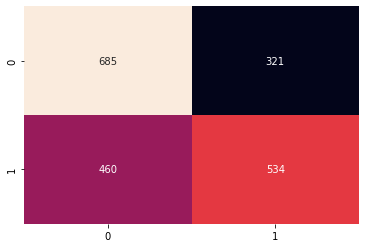

In [91]:
# Plot the confusion matrix
ax = sns.heatmap(
    confusion_matrix(y_test, y_pred), 
    annot=True, 
    cbar=False, 
    fmt='d'
)

**Sarcasm Prediction using LSTM Neural Networks on raw text**

In [92]:
# Split data into train-test chunks
Xtrain = train[['comment']]
Xtest = test[['comment']]
ytrain = train[['label']]
ytest = test[['label']]

In [93]:
# Hyperparameters of the model
vocab_size = 3000 # choose based on statistics
oov_tok = ''
embedding_dim = 100
max_length = 200 # choose based on statistics, for example 150 to 200
padding_type='post'
trunc_type='post'

In [94]:
# tokenize sentences
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(Xtrain['comment'].values)

In [95]:
# convert train dataset to sequence and pad sequences
Xtrain = tokenizer.texts_to_sequences(Xtrain['comment'].values)

In [96]:
Xtrain = pad_sequences(Xtrain, padding='post', truncating='post', maxlen=len(Xtrain[0]))

In [97]:
# convert Test dataset to sequence and pad sequences
Xtest = tokenizer.texts_to_sequences(Xtest['comment'].values)
Xtest = pad_sequences(Xtest, padding='post', truncating='post', maxlen=len(Xtrain[0]))

In [98]:
# Build the model
model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=Xtrain.shape[1]),
    Bidirectional(LSTM(196)),
#     Dense(24, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [99]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tensorflow.keras.metrics.AUC(), 'accuracy'])

In [100]:
model.fit(Xtrain, ytrain, batch_size=10, epochs=5)

Epoch 1/5
1021/1021 [==============================] - 16s 13ms/step - loss: 0.6455 - auc_2: 0.6656 - accuracy: 0.6222
Epoch 2/5
1021/1021 [==============================] - 14s 13ms/step - loss: 0.5651 - auc_2: 0.7764 - accuracy: 0.7040
Epoch 3/5
1021/1021 [==============================] - 14s 14ms/step - loss: 0.4850 - auc_2: 0.8446 - accuracy: 0.7652
Epoch 4/5
1021/1021 [==============================] - 14s 14ms/step - loss: 0.4062 - auc_2: 0.8949 - accuracy: 0.8119
Epoch 5/5
1021/1021 [==============================] - 14s 14ms/step - loss: 0.3371 - auc_2: 0.9278 - accuracy: 0.8459


In [101]:
model.evaluate(Xtest, ytest, batch_size=10)

100131/100131 [==============================] - 321s 3ms/step - loss: 0.9903 - auc_2: 0.6516 - accuracy: 0.6123


[0.990349292755127, 0.6516327261924744, 0.6123354434967041]

In [102]:
# Use the model for predictions and convert probabilities above 0.5 to 1
y_pred = model.predict(Xtest)
y_pred = y_pred > 0.5

31291/31291 [==============================] - 199s 6ms/step


In [103]:
# View the classification report
print(classification_report(ytest, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.57      0.60    500629
           1       0.60      0.65      0.63    500680

    accuracy                           0.61   1001309
   macro avg       0.61      0.61      0.61   1001309
weighted avg       0.61      0.61      0.61   1001309



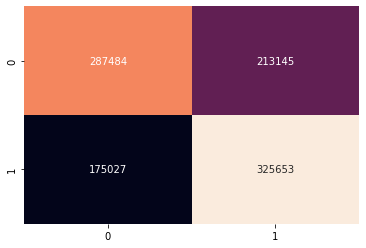

In [104]:
# Plot the confusion matrix
ax = sns.heatmap(
    confusion_matrix(ytest, y_pred), 
    annot=True, 
    cbar=False, 
    fmt='d'
)

**Sarcasm Prediction using Cohere.ai on raw text**

In [105]:
cohere_keys = 'IbsZe1jhUFWOuE6UkjLvxvsQMTVTr7D5FJQIhcvj'

In [106]:
import cohere
from cohere.responses.classify import Example

In [107]:
co = cohere.Client(cohere_keys)

In [108]:
co_train, co_test = train_test_split(pd.concat([train, test]), train_size=360, test_size=90, random_state=9)

In [109]:
co_train.shape, co_test.shape

((360, 12), (90, 12))

In [110]:
co_train.replace({'label': {1: 'sarcasm', 0: 'no sarcasm'}}, inplace=True)
co_test.replace({'label': {1: 'sarcasm', 0: 'no sarcasm'}}, inplace=True)

In [111]:
classifications = co.classify(
  model='embed-english-v2.0',
  inputs=[row for row in co_test.comment],
  examples=[Example(row.comment, row.label) for index, row in co_train.iterrows()]
)

In [112]:
y_pred = [1 if result.prediction == 'sarcasm' else 0 for result in classifications.classifications]

In [113]:
co_train.replace({'label': {'sarcasm': 1, 'no sarcasm': 0}}, inplace=True)
co_test.replace({'label': {'sarcasm': 1, 'no sarcasm': 0}}, inplace=True)

In [114]:
# View the classification report
print(classification_report(co_test.label.values, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.65      0.67        52
           1       0.55      0.58      0.56        38

    accuracy                           0.62        90
   macro avg       0.61      0.62      0.62        90
weighted avg       0.63      0.62      0.62        90



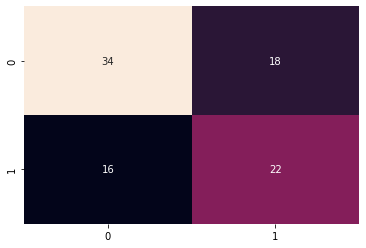

In [115]:
# Plot the confusion matrix
ax = sns.heatmap(
    confusion_matrix(co_test.label.values, y_pred), 
    annot=True, 
    cbar=False, 
    fmt='d'
)

**Sarcasm prediction using embedding from the sentence-transformers library**

In [128]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [129]:
# df['embeddings_st'] = df['comment'].apply(model.encode)

In [130]:
# Split data into train-test chunks
Xtrain = train[['comment']]
Xtest = test[['comment']]
ytrain = train[['label']]
ytest = test[['label']]

In [131]:
res_train = model.encode(Xtrain['comment'].values, show_progress_bar=True)

Batches: 100%|██████████| 319/319 [00:51<00:00,  6.23it/s]


In [132]:
res_test = model.encode(Xtest['comment'].values, show_progress_bar=True)

Batches: 100%|██████████| 31291/31291 [1:05:19<00:00,  7.98it/s] 


In [133]:
# Pipeline to create bag of words, test scalling the data, then test various models
pipe = Pipeline([
    ('preprocess', None),
    ('model', LogisticRegression())
])

In [134]:
# Set grid search parameters
hyperparams = {
    'preprocess': [StandardScaler(with_mean=False), MaxAbsScaler(), Normalizer(copy=False), None],
    'model': [LinearSVC(), LogisticRegression(), DecisionTreeClassifier(), RandomForestClassifier(), 
             GradientBoostingClassifier(), GaussianNB(), MLPClassifier()]
}

In [135]:
# Configure pipeline for grid search
grid = GridSearchCV(
    estimator=pipe,
    param_grid=hyperparams,
    scoring='roc_auc',
    n_jobs=-1,
    cv=2
)

In [136]:
# Train a pipeline using the grid search settings to predict sarcasm
cv = grid.fit(res_train, ytrain)

/Users/doski/miniconda3/envs/getinno-env/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [137]:
cv.best_estimator_

Pipeline(steps=[('preprocess', None), ('model', LogisticRegression())])

In [138]:
cv.best_score_

0.6891370230711701

In [139]:
# Evaluate best model on test data
pred = cv.best_estimator_.predict(res_test)

In [140]:
# View the classification report
print(classification_report(ytest, pred))

              precision    recall  f1-score   support

           0       0.65      0.66      0.65    500629
           1       0.65      0.65      0.65    500680

    accuracy                           0.65   1001309
   macro avg       0.65      0.65      0.65   1001309
weighted avg       0.65      0.65      0.65   1001309



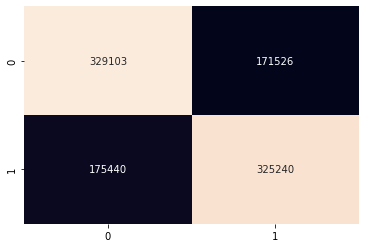

In [141]:
# Plot the confusion matrix
ax = sns.heatmap(
    confusion_matrix(ytest, pred), 
    annot=True, 
    cbar=False, 
    fmt='d'
)

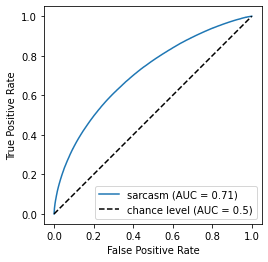

In [142]:
# Plot ROC and get the AUC value
ax = RocCurveDisplay.from_estimator(
    cv.best_estimator_,
    res_test,
    ytest,
    name='sarcasm'
)
plt.plot([0, 1], [0, 1], 'k--', label='chance level (AUC = 0.5)')
plt.axis('square')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()